### Identifying Bias

#### **Method 1: Independent Demographic Parity**

#### STEP 1.1: Fit data to a random forest regressor 

In [3312]:
import pandas as pd

df = pd.read_csv('PCA_final.csv')

X = df[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
            'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population']]
y = df['inc_case']
sensitive_feature = df['liberalism']

In [3313]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (594, 13), y_train shape: (594,)
X_test shape: (255, 13), y_test shape: (255,)


In [3314]:
from sklearn.ensemble import RandomForestRegressor

# Define an Random Forest object using RandomForestRegressor 
rf_model = RandomForestRegressor()

# Fit the model
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [3315]:
# Make predictions
y_pred = rf_model.predict(X_test)

#### STEP 1.2: Calculate Demographic Parity using StratifiedKFold

##### StratifiedKFold
1. Fixed random seed: "random_state=42" ensures that the code produces the same results each time it is ran.
2. Stratified Cross-Validation: ensures that each fold represents the distribution of liberal and conservative states of the overall dataset, making the evaluation results reliable.

In [3316]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Initialize StratifiedKFold with 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List to store MAE for liberal and conservative states in each fold
liberal_mae_list = []
conservative_mae_list = []

# Loop through each fold of StratifiedKFold
for train_index, test_index in skf.split(X, sensitive_feature):

    # Split the data into training and testing sets for this fold
    # Ensures that each fold has a similar proportion of liberal and conservative states as the overall dataset
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train RandomForestRegressor on the training data
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = rf_model.predict(X_test)

    # Convert y_pred to a pandas Series with the same index as y_test
    y_pred_series = pd.Series(y_pred, index=y_test.index)

    # Separate the predictions into liberal and conservative states
    liberal_indices = X_test[sensitive_feature[test_index] == 1].index
    conservative_indices = X_test[sensitive_feature[test_index] == 0].index

    # Calculate MAE for liberal (blue) states
    liberal_mae = mean_absolute_error(y_test.loc[liberal_indices], y_pred_series.loc[liberal_indices])
    liberal_mae_list.append(liberal_mae)

    # Calculate MAE for conservative (red) states
    conservative_mae = mean_absolute_error(y_test.loc[conservative_indices], y_pred_series.loc[conservative_indices])
    conservative_mae_list.append(conservative_mae)

# Calculate the mean and standard deviation of the MAEs
mean_liberal_mae = np.mean(liberal_mae_list)
mean_conservative_mae = np.mean(conservative_mae_list)
mae_difference = mean_liberal_mae - mean_conservative_mae

print(f"Mean MAE for liberal (blue) states: {mean_liberal_mae}")
print(f"Mean MAE for conservative (red) states: {mean_conservative_mae}")
print(f"Difference in MAE (liberal - conservative): {mae_difference}")


Mean MAE for liberal (blue) states: 37007.8884747191
Mean MAE for conservative (red) states: 21599.283916290275
Difference in MAE (liberal - conservative): 15408.604558428822


#### STEP 1.4: Calculate differences between evaluation metrics between liberal (blue) and conservative (red) states

In [3317]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Initialize StratifiedKFold with 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store evaluation metrics for liberal and conservative states in each fold
liberal_mse_list = []
liberal_rmse_list = []
liberal_coverage_list = []
liberal_bias_list = []

conservative_mse_list = []
conservative_rmse_list = []
conservative_coverage_list = []
conservative_bias_list = []

# List to store predictions
y_pred_list = []
y_true_list = []
sensitive_feature_list = []
X_test_list = []

# Function to calculate coverage and bias
def calculate_coverage_bias(y_true, y_pred):
    bias = (y_pred - y_true).mean()
    coverage = ((y_pred >= y_true.min()) & (y_pred <= y_true.max())).mean()
    return coverage, bias

# Loop through each fold of StratifiedKFold
for train_index, test_index in skf.split(X, sensitive_feature):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Store test data for later use
    X_test_list.append(X_test)
    y_true_list.append(y_test)
    sensitive_feature_list.append(sensitive_feature.iloc[test_index])

    # Train RandomForestRegressor without sample weights
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = rf_model.predict(X_test)
    y_pred_list.append(y_pred)

    # Calculate RMSE, MAE, coverage, and bias for liberal and conservative states
    liberal_indices = sensitive_feature.iloc[test_index] == 1
    conservative_indices = sensitive_feature.iloc[test_index] == 0

    liberal_mse = mean_squared_error(y_test[liberal_indices], y_pred[liberal_indices])
    liberal_rmse = np.sqrt(liberal_mse)
    liberal_coverage, liberal_bias = calculate_coverage_bias(y_test[liberal_indices], y_pred[liberal_indices])

    conservative_mse = mean_squared_error(y_test[conservative_indices], y_pred[conservative_indices])
    conservative_rmse = np.sqrt(conservative_mse)
    conservative_coverage, conservative_bias = calculate_coverage_bias(y_test[conservative_indices], y_pred[conservative_indices])

    # Append evaluation metrics to the corresponding lists
    liberal_mse_list.append(liberal_mse)
    liberal_rmse_list.append(liberal_rmse)
    liberal_coverage_list.append(liberal_coverage)
    liberal_bias_list.append(liberal_bias)

    conservative_mse_list.append(conservative_mse)
    conservative_rmse_list.append(conservative_rmse)
    conservative_coverage_list.append(conservative_coverage)
    conservative_bias_list.append(conservative_bias)

# Calculate the mean and standard deviation of the evaluation metrics
mean_liberal_mse = np.mean(liberal_mse_list)
mean_liberal_rmse = np.mean(liberal_rmse_list)
mean_liberal_coverage = np.mean(liberal_coverage_list)
mean_liberal_bias = np.mean(liberal_bias_list)

mean_conservative_mse = np.mean(conservative_mse_list)
mean_conservative_rmse = np.mean(conservative_rmse_list)
mean_conservative_coverage = np.mean(conservative_coverage_list)
mean_conservative_bias = np.mean(conservative_bias_list)

# Print the results
print("Metrics for Liberal (Blue) States:")
print("Mean MSE:", mean_liberal_mse)
print("Mean RMSE:", mean_liberal_rmse)
print("Mean Coverage:", mean_liberal_coverage)
print("Mean Bias:", mean_liberal_bias)
print("\nMetrics for Conservative (Red) States:")
print("Mean MSE:", mean_conservative_mse)
print("Mean RMSE:", mean_conservative_rmse)
print("Mean Coverage:", mean_conservative_coverage)
print("Mean Bias:", mean_conservative_bias)

Metrics for Liberal (Blue) States:
Mean MSE: 18884046674.333153
Mean RMSE: 124300.13073553478
Mean Coverage: 0.9909346271705821
Mean Bias: -5965.695497701736

Metrics for Conservative (Red) States:
Mean MSE: 3768320938.00295
Mean RMSE: 56221.83120266702
Mean Coverage: 0.9926528154170431
Mean Bias: 7709.711258657029


#### EXTRA STEP: Calculate Disparate Impact Ratio

In [3318]:
# Compute Disparate Impact (DI) ratio using RMSE
DI_ratio = mean_conservative_rmse / mean_liberal_rmse
print("Disparate Impact (DI) Ratio (RMSE):", DI_ratio)

DI_ratio_bias = mean_conservative_bias / mean_liberal_bias
print("Disparate Impact (DI) Ratio (Bias):", DI_ratio_bias)

Disparate Impact (DI) Ratio (RMSE): 0.4523070962997337
Disparate Impact (DI) Ratio (Bias): -1.292340727351433


/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_31048/18864287.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y=metrics_df['MSE'], ax=axes[0, 0], palette="Blues_d")
/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_31048/18864287.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y=metrics_df['RMSE'], ax=axes[0, 1], palette="Greens_d")
/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_31048/18864287.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.i

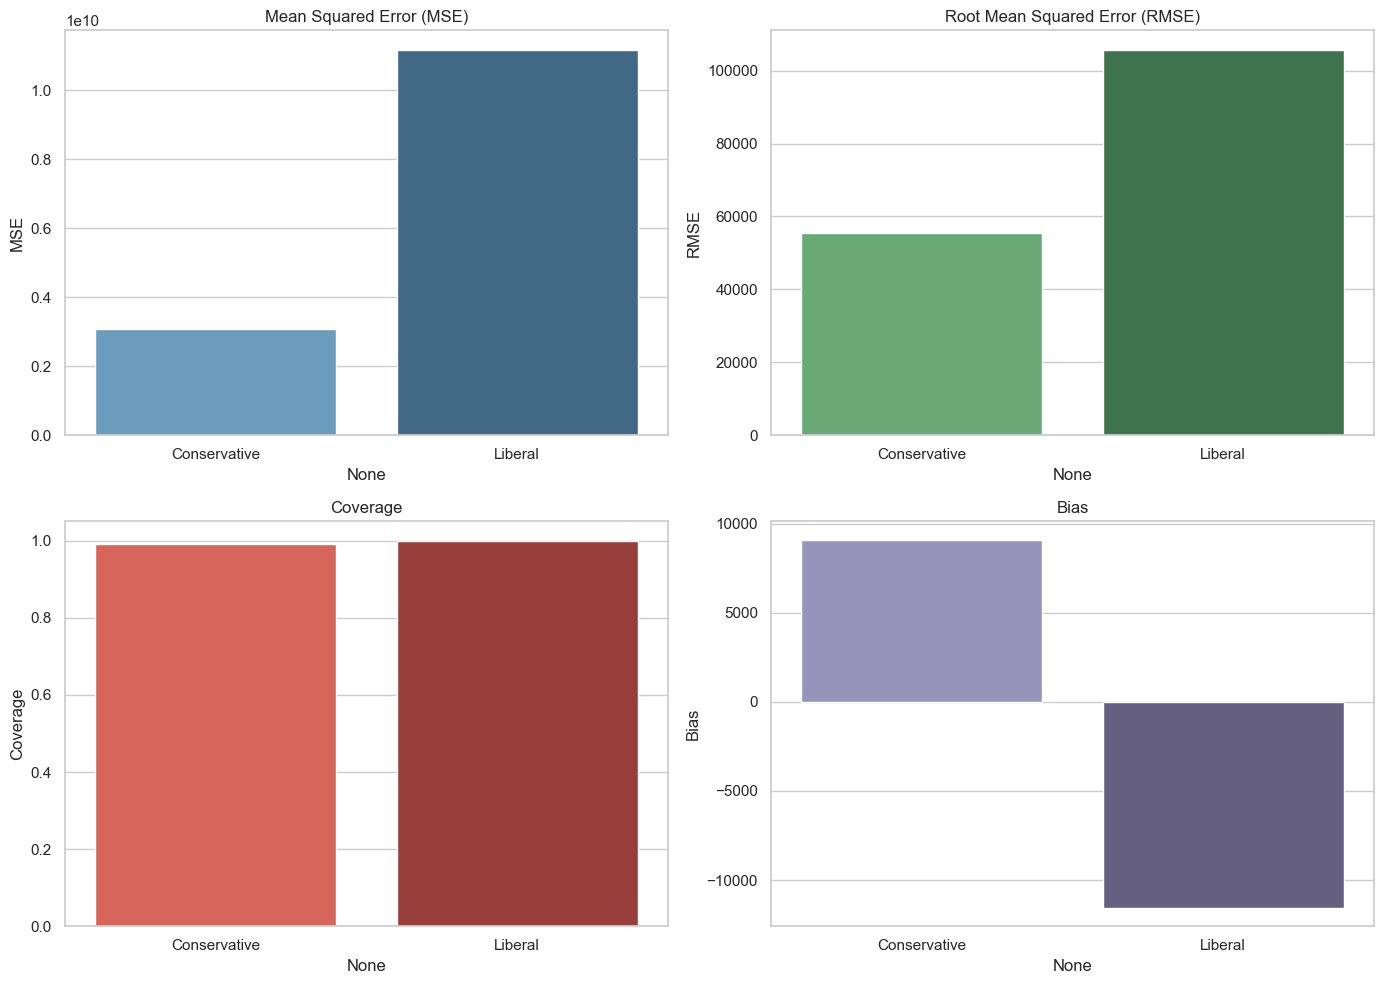

In [3319]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot MSE
sns.barplot(x=metrics_df.index, y=metrics_df['MSE'], ax=axes[0, 0], palette="Blues_d")
axes[0, 0].set_title('Mean Squared Error (MSE)')
axes[0, 0].set_ylabel('MSE')

# Plot RMSE
sns.barplot(x=metrics_df.index, y=metrics_df['RMSE'], ax=axes[0, 1], palette="Greens_d")
axes[0, 1].set_title('Root Mean Squared Error (RMSE)')
axes[0, 1].set_ylabel('RMSE')

# Plot Coverage
sns.barplot(x=metrics_df.index, y=metrics_df['Coverage'], ax=axes[1, 0], palette="Reds_d")
axes[1, 0].set_title('Coverage')
axes[1, 0].set_ylabel('Coverage')

# Plot Bias
sns.barplot(x=metrics_df.index, y=metrics_df['Bias'], ax=axes[1, 1], palette="Purples_d")
axes[1, 1].set_title('Bias')
axes[1, 1].set_ylabel('Bias')

# Adjust layout
plt.tight_layout()
plt.show()


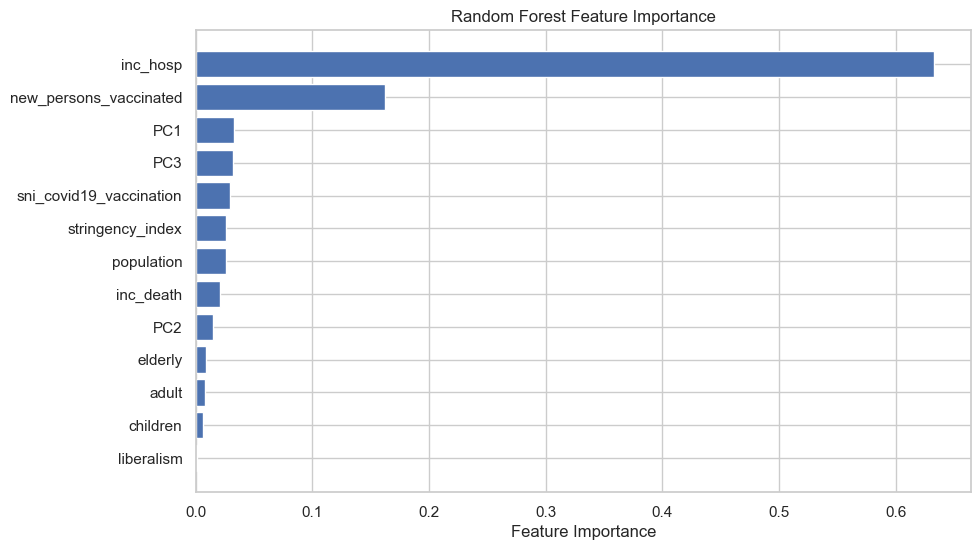

In [3320]:
# Get feature importances from the random forest model
feature_importances = rf_model.feature_importances_

# Get the names of features
feature_names = list(X.columns)

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

#### Method 2: Conditional Independent Demographic Parity

#### STEP 2.1: Create an interaction variable

In [3321]:
df['int:liberalism_stringency'] = df['liberalism'] * df['stringency_category']

display(df)

,date,location_key,inc_case,inc_hosp,inc_death,sni_covid19_vaccination,liberalism,children,adult,elderly,...,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,population,PC1,PC2,PC3,int:liberalism_stringency
0,2021-01,Alabama,112124.000,1.371,1.584,0.033,0.000,-0.232,-0.237,-0.199,...,-1.240,-1.011,-0.710,-0.403,1.150,-0.216,-2.396,-0.262,-0.155,0.000
1,2021-01,Alaska,8604.000,-0.537,-0.540,1.081,1.000,-0.755,-0.762,-0.850,...,-1.400,-0.905,-1.317,-0.913,1.940,-0.216,-3.198,0.417,0.068,2.000
2,2021-01,Arizona,262750.000,2.367,2.944,1.492,1.000,0.135,0.060,0.166,...,-1.785,-1.154,-0.304,-1.670,2.105,-0.216,-3.499,0.563,-1.172,3.000
3,2021-01,Arkansas,80418.000,0.282,0.466,0.248,0.000,-0.459,-0.484,-0.474,...,-1.284,-0.875,-0.394,-0.124,1.093,-0.216,-2.132,-0.504,-0.224,0.000
4,2021-01,California,1180351.000,10.207,11.822,1.098,1.000,4.450,4.492,4.087,...,-2.013,-1.051,-1.862,-2.430,2.871,-0.216,-5.162,1.488,-0.310,3.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,2022-05,Virginia,14020.000,-0.454,-0.553,-1.122,1.000,0.236,0.292,0.235,...,0.399,-0.152,-0.274,0.714,-0.307,-0.098,0.267,-0.542,0.474,1.000
845,2022-05,Washington,15606.000,-0.449,-0.568,-1.060,1.000,0.072,0.117,0.084,...,0.232,0.544,0.010,0.423,-1.013,-0.098,1.036,-0.189,0.518,1.000
846,2022-05,West Virginia,1726.000,-0.538,-0.568,-1.299,0.000,-0.653,-0.638,-0.616,...,0.492,-0.259,1.600,1.075,-1.061,-0.098,1.682,-1.320,-0.813,0.000
847,2022-05,Wisconsin,12420.000,-0.470,-0.547,-1.243,0.000,-0.127,-0.121,-0.077,...,1.396,1.036,0.425,1.386,-1.343,-0.098,2.600,-0.461,0.817,0.000


#### STEP 2.2: Fit data to a random forest regressor 

In [3322]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

X = df[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_category', 'inc_death',
        'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population', 'int:liberalism_stringency']]
y = df['inc_case']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

#### STEP 2.4: Calculate Demographic Parity using StratifiedKFold

In [3323]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Initialize StratifiedKFold with 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List to store MAE for liberal and conservative states in each fold
liberal_mae_list = []
conservative_mae_list = []

# Loop through each fold of StratifiedKFold
for train_index, test_index in skf.split(X, sensitive_feature):

    # Split the data into training and testing sets for this fold
    # Ensures that each fold has a similar proportion of liberal and conservative states as the overall dataset
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train RandomForestRegressor on the training data
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = rf_model.predict(X_test)

    # Convert y_pred to a pandas Series with the same index as y_test
    y_pred_series = pd.Series(y_pred, index=y_test.index)

    # Separate the predictions into liberal and conservative states
    liberal_indices = X_test[sensitive_feature[test_index] == 1].index
    conservative_indices = X_test[sensitive_feature[test_index] == 0].index

    # Calculate MAE for liberal (blue) states
    liberal_mae = mean_absolute_error(y_test.loc[liberal_indices], y_pred_series.loc[liberal_indices])
    liberal_mae_list.append(liberal_mae)

    # Calculate MAE for conservative (red) states
    conservative_mae = mean_absolute_error(y_test.loc[conservative_indices], y_pred_series.loc[conservative_indices])
    conservative_mae_list.append(conservative_mae)

# Calculate the mean and standard deviation of the MAEs
mean_liberal_mae = np.mean(liberal_mae_list)
mean_conservative_mae = np.mean(conservative_mae_list)
mae_difference = mean_liberal_mae - mean_conservative_mae

print(f"Mean MAE for liberal (blue) states: {mean_liberal_mae}")
print(f"Mean MAE for conservative (red) states: {mean_conservative_mae}")
print(f"Difference in MAE (liberal - conservative): {mae_difference}")

Mean MAE for liberal (blue) states: 37700.819868232895
Mean MAE for conservative (red) states: 21556.344820535982
Difference in MAE (liberal - conservative): 16144.475047696913


#### STEP 2.5: Calculate differences between evaluation metrics between liberal (blue) and conservative (red) states

In [3324]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Initialize StratifiedKFold with 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store evaluation metrics for liberal and conservative states in each fold
liberal_mse_list = []
liberal_rmse_list = []
liberal_coverage_list = []
liberal_bias_list = []

conservative_mse_list = []
conservative_rmse_list = []
conservative_coverage_list = []
conservative_bias_list = []

# List to store predictions
y_pred_list = []
y_true_list = []
sensitive_feature_list = []
X_test_list = []

# Function to calculate coverage and bias
def calculate_coverage_bias(y_true, y_pred):
    bias = (y_pred - y_true).mean()
    coverage = ((y_pred >= y_true.min()) & (y_pred <= y_true.max())).mean()
    return coverage, bias

# Loop through each fold of StratifiedKFold
for train_index, test_index in skf.split(X, sensitive_feature):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Store test data for later use
    X_test_list.append(X_test)
    y_true_list.append(y_test)
    sensitive_feature_list.append(sensitive_feature.iloc[test_index])

    # Train RandomForestRegressor without sample weights
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = rf_model.predict(X_test)
    y_pred_list.append(y_pred)

    # Calculate RMSE, MAE, coverage, and bias for liberal and conservative states
    liberal_indices = sensitive_feature.iloc[test_index] == 1
    conservative_indices = sensitive_feature.iloc[test_index] == 0

    liberal_mse = mean_squared_error(y_test[liberal_indices], y_pred[liberal_indices])
    liberal_rmse = np.sqrt(liberal_mse)
    liberal_coverage, liberal_bias = calculate_coverage_bias(y_test[liberal_indices], y_pred[liberal_indices])

    conservative_mse = mean_squared_error(y_test[conservative_indices], y_pred[conservative_indices])
    conservative_rmse = np.sqrt(conservative_mse)
    conservative_coverage, conservative_bias = calculate_coverage_bias(y_test[conservative_indices], y_pred[conservative_indices])

    # Append evaluation metrics to the corresponding lists
    liberal_mse_list.append(liberal_mse)
    liberal_rmse_list.append(liberal_rmse)
    liberal_coverage_list.append(liberal_coverage)
    liberal_bias_list.append(liberal_bias)

    conservative_mse_list.append(conservative_mse)
    conservative_rmse_list.append(conservative_rmse)
    conservative_coverage_list.append(conservative_coverage)
    conservative_bias_list.append(conservative_bias)

# Calculate the mean and standard deviation of the evaluation metrics
mean_liberal_mse = np.mean(liberal_mse_list)
mean_liberal_rmse = np.mean(liberal_rmse_list)
mean_liberal_coverage = np.mean(liberal_coverage_list)
mean_liberal_bias = np.mean(liberal_bias_list)

mean_conservative_mse = np.mean(conservative_mse_list)
mean_conservative_rmse = np.mean(conservative_rmse_list)
mean_conservative_coverage = np.mean(conservative_coverage_list)
mean_conservative_bias = np.mean(conservative_bias_list)

# Print the results
print("Metrics for Liberal (Blue) States:")
print("Mean MSE:", mean_liberal_mse)
print("Mean RMSE:", mean_liberal_rmse)
print("Mean Coverage:", mean_liberal_coverage)
print("Mean Bias:", mean_liberal_bias)
print("\nMetrics for Conservative (Red) States:")
print("Mean MSE:", mean_conservative_mse)
print("Mean RMSE:", mean_conservative_rmse)
print("Mean Coverage:", mean_conservative_coverage)
print("Mean Bias:", mean_conservative_bias)

Metrics for Liberal (Blue) States:
Mean MSE: 18878008587.626137
Mean RMSE: 124799.48262667684
Mean Coverage: 0.9909346271705821
Mean Bias: -5547.3610280898865

Metrics for Conservative (Red) States:
Mean MSE: 3551914668.975053
Mean RMSE: 54093.50750707162
Mean Coverage: 0.9926528154170431
Mean Bias: 8337.324202047577


In [3325]:
import pandas as pd

# Function to calculate coverage and bias
def calculate_coverage_bias(y_true, y_pred):
    bias = (y_pred - y_true).mean()
    coverage = ((y_pred >= y_true.min()) & (y_pred <= y_true.max())).mean()
    return coverage, bias

# Interaction groups
interaction_groups = [
    (1, 1),
    (1, 2),
    (1, 3),
    (0, 1),
    (0, 2),
    (0, 3)
]

# Dictionary to store results for interaction groups
interaction_results = {group: {'y_true': [], 'y_pred': []} for group in interaction_groups}

# Loop through each fold's stored predictions and true values
for fold_index in range(len(y_true_list)):
    X_test = X_test_list[fold_index]
    y_test = y_true_list[fold_index]
    y_pred = y_pred_list[fold_index]

    # Store predictions and true values for interaction groups
    for liberalism, stringency in interaction_results.keys():
        group_mask = (X_test['liberalism'] == liberalism) & (X_test['stringency_category'] == stringency)
        interaction_results[(liberalism, stringency)]['y_true'].extend(y_test[group_mask].tolist())
        interaction_results[(liberalism, stringency)]['y_pred'].extend(y_pred[group_mask].tolist())

# Calculate metrics for interaction groups
interaction_metrics = []
for group, values in interaction_results.items():
    y_true = np.array(values['y_true'])
    y_pred = np.array(values['y_pred'])
    if len(y_true) > 0:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mse = mean_squared_error(y_true, y_pred)
        bias = (y_pred - y_true).mean()
        coverage = ((y_pred >= y_true.min()) & (y_pred <= y_true.max())).mean()
        interaction_metrics.append({
            'Political Affiliation': 'Liberal' if group[0] == 1 else 'Conservative',
            'Stringency Category': group[1],
            'RMSE': rmse,
            'MSE': mse,
            'Bias': bias,
            'Coverage': coverage
        })

# Convert interaction metrics to DataFrame
interaction_df = pd.DataFrame(interaction_metrics)

# Print the DataFrame
display(interaction_df)

,Political Affiliation,Stringency Category,RMSE,MSE,Bias,Coverage
0,Liberal,1,91411.902,8356135847.420,-7643.882,1.000
1,Liberal,2,211578.545,44765480606.353,-14318.862,1.000
2,Liberal,3,93859.374,8809582024.971,38846.830,0.974
3,Conservative,1,60739.355,3689269283.143,3663.211,1.000
4,Conservative,2,51272.249,2628843519.989,20837.541,0.989
5,Conservative,3,87605.799,7674775943.522,29716.157,0.917


#### STEP 2.6: Calculate Disparate Impact Ratio for red and blue states based on different stringency index category

In [3326]:
# Calculate DI ratios for RMSE and Bias
di_ratios = []
for stringency_category in interaction_df['Stringency Category'].unique():
    liberal_rmse = interaction_df[(interaction_df['Political Affiliation'] == 'Liberal') & (interaction_df['Stringency Category'] == stringency_category)]['RMSE'].values[0]
    conservative_rmse = interaction_df[(interaction_df['Political Affiliation'] == 'Conservative') & (interaction_df['Stringency Category'] == stringency_category)]['RMSE'].values[0]
    rmse_di_ratio = conservative_rmse / liberal_rmse
    
    liberal_bias = interaction_df[(interaction_df['Political Affiliation'] == 'Liberal') & (interaction_df['Stringency Category'] == stringency_category)]['Bias'].values[0]
    conservative_bias = interaction_df[(interaction_df['Political Affiliation'] == 'Conservative') & (interaction_df['Stringency Category'] == stringency_category)]['Bias'].values[0]
    bias_di_ratio = conservative_bias / liberal_bias

    di_ratios.append({
        'Stringency Category': stringency_category,
        'RMSE DI Ratio': rmse_di_ratio,
        'Bias DI Ratio': bias_di_ratio
    })

# Convert DI ratios to DataFrame
di_ratio_df = pd.DataFrame(di_ratios)

# Print the DI ratio DataFrame
print(di_ratio_df)

   Stringency Category  RMSE DI Ratio  Bias DI Ratio
0                    1          0.664         -0.479
1                    2          0.242         -1.455
2                    3          0.933          0.765


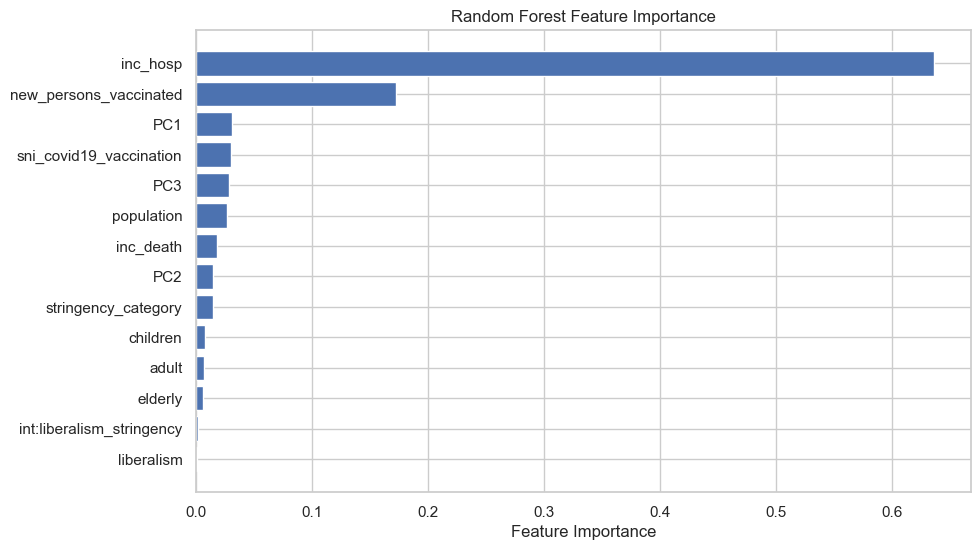

In [3327]:
# Get feature importances from the random forest model
feature_importances = rf_model.feature_importances_

# Get the names of features
feature_names = list(X.columns)

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

### Mitigating Bias

#### **Reweight model for each StratifiedKFold and calculate Demographic Parity** 

In [3328]:
# Define features and target variable
X = df[['sni_covid19_vaccination', 'new_persons_vaccinated', 'stringency_index', 'inc_death',
        'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'population']]
y = df['inc_case']
liberalism = df['liberalism']

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

liberal_mae_list = []
conservative_mae_list = []

for train_index, test_index in skf.split(X, liberalism):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Calculate the sample weights based on the training data
    liberal_count_train = sum(df.loc[X_train.index]['liberalism'] == 1)
    conservative_count_train = sum(df.loc[X_train.index]['liberalism'] == 0)

    liberal_weight_train = (1 / liberal_count_train) ** 0.5
    conservative_weight_train = (1 / conservative_count_train) ** 0.5

    # Assign sample weights
    sample_weight_train = np.array([liberal_weight_train if label == 1 else conservative_weight_train for label in df.loc[X_train.index]['liberalism']])
    
    # Train RandomForestRegressor with reweighting
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train, sample_weight=sample_weight_train)
    y_pred = rf_model.predict(X_test)

    # Convert y_pred to a pandas Series with the same index as y_test
    y_pred_series = pd.Series(y_pred, index=y_test.index)

    # Separate the predictions into red and blue states
    liberal_indices = X_test[df.loc[X_test.index]['liberalism'] == 1].index
    conservative_indices = X_test[df.loc[X_test.index]['liberalism'] == 0].index

    # Calculate MAE for liberal (blue) states
    liberal_mae = mean_absolute_error(y_test.loc[liberal_indices], y_pred_series.loc[liberal_indices])
    liberal_mae_list.append(liberal_mae)

    # Calculate MAE for conservative (red) states
    conservative_mae = mean_absolute_error(y_test.loc[conservative_indices], y_pred_series.loc[conservative_indices])
    conservative_mae_list.append(conservative_mae)

# Calculate the mean and standard deviation of the MAEs
mean_liberal_mae = np.mean(liberal_mae_list)
mean_conservative_mae = np.mean(conservative_mae_list)
mae_difference = mean_liberal_mae - mean_conservative_mae

print(f"Mean MAE for liberal (blue) states: {mean_liberal_mae}")
print(f"Mean MAE for conservative (red) states: {mean_conservative_mae}")
print(f"Difference in MAE (liberal - conservative): {mae_difference}")

Mean MAE for liberal (blue) states: 36574.96578472932
Mean MAE for conservative (red) states: 21818.62274585968
Difference in MAE (liberal - conservative): 14756.34303886964


In [3329]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Initialize StratifiedKFold with 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store evaluation metrics for liberal and conservative states in each fold
liberal_mse_list = []
liberal_rmse_list = []
liberal_coverage_list = []
liberal_bias_list = []

conservative_mse_list = []
conservative_rmse_list = []
conservative_coverage_list = []
conservative_bias_list = []

# List to store predictions
y_pred_list = []
y_true_list = []
sensitive_feature_list = []
X_test_list = []

# Function to calculate coverage and bias
def calculate_coverage_bias(y_true, y_pred):
    bias = (y_pred - y_true).mean()
    coverage = ((y_pred >= y_true.min()) & (y_pred <= y_true.max())).mean()
    return coverage, bias

# Loop through each fold of StratifiedKFold
for train_index, test_index in skf.split(X, sensitive_feature):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Store test data for later use
    X_test_list.append(X_test)
    y_true_list.append(y_test)
    sensitive_feature_list.append(sensitive_feature.iloc[test_index])

    # Train RandomForestRegressor without sample weights
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = rf_model.predict(X_test)
    y_pred_list.append(y_pred)

    # Calculate RMSE, MAE, coverage, and bias for liberal and conservative states
    liberal_indices = sensitive_feature.iloc[test_index] == 1
    conservative_indices = sensitive_feature.iloc[test_index] == 0

    liberal_mse = mean_squared_error(y_test[liberal_indices], y_pred[liberal_indices])
    liberal_rmse = np.sqrt(liberal_mse)
    liberal_coverage, liberal_bias = calculate_coverage_bias(y_test[liberal_indices], y_pred[liberal_indices])

    conservative_mse = mean_squared_error(y_test[conservative_indices], y_pred[conservative_indices])
    conservative_rmse = np.sqrt(conservative_mse)
    conservative_coverage, conservative_bias = calculate_coverage_bias(y_test[conservative_indices], y_pred[conservative_indices])

    # Append evaluation metrics to the corresponding lists
    liberal_mse_list.append(liberal_mse)
    liberal_rmse_list.append(liberal_rmse)
    liberal_coverage_list.append(liberal_coverage)
    liberal_bias_list.append(liberal_bias)

    conservative_mse_list.append(conservative_mse)
    conservative_rmse_list.append(conservative_rmse)
    conservative_coverage_list.append(conservative_coverage)
    conservative_bias_list.append(conservative_bias)

# Calculate the mean and standard deviation of the evaluation metrics
mean_liberal_mse = np.mean(liberal_mse_list)
mean_liberal_rmse = np.mean(liberal_rmse_list)
mean_liberal_coverage = np.mean(liberal_coverage_list)
mean_liberal_bias = np.mean(liberal_bias_list)

mean_conservative_mse = np.mean(conservative_mse_list)
mean_conservative_rmse = np.mean(conservative_rmse_list)
mean_conservative_coverage = np.mean(conservative_coverage_list)
mean_conservative_bias = np.mean(conservative_bias_list)

# Print the results
print("Metrics for Liberal (Blue) States:")
print("Mean MSE:", mean_liberal_mse)
print("Mean RMSE:", mean_liberal_rmse)
print("Mean Coverage:", mean_liberal_coverage)
print("Mean Bias:", mean_liberal_bias)
print("\nMetrics for Conservative (Red) States:")
print("Mean MSE:", mean_conservative_mse)
print("Mean RMSE:", mean_conservative_rmse)
print("Mean Coverage:", mean_conservative_coverage)
print("Mean Bias:", mean_conservative_bias)

Metrics for Liberal (Blue) States:
Mean MSE: 18556708447.06727
Mean RMSE: 123847.60786203756
Mean Coverage: 0.9909346271705821
Mean Bias: -6250.545476251276

Metrics for Conservative (Red) States:
Mean MSE: 3977646676.424062
Mean RMSE: 56970.31064853653
Mean Coverage: 0.9926528154170431
Mean Bias: 8835.673792833484


In [3330]:
# Compute Disparate Impact (DI) ratio using RMSE
DI_ratio = mean_conservative_rmse / mean_liberal_rmse
print("Disparate Impact (DI) Ratio (RMSE):", DI_ratio)

DI_ratio_bias = mean_conservative_bias / mean_liberal_bias
print("Disparate Impact (DI) Ratio (Bias):", DI_ratio_bias)

Disparate Impact (DI) Ratio (RMSE): 0.4600033188529544
Disparate Impact (DI) Ratio (Bias): -1.41358443457524
